# Introduction to Missing Data 

- [Handling Missing Data](https://jakevdp.github.io/PythonDataScienceHandbook/03.04-missing-values.html)
- [Working with missing data](https://pandas.pydata.org/docs/user_guide/missing_data.html#values-considered-missing)

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

Missing or duplicate data may exist in a data set for a number of different reasons:
- Values are missed during data acquisition process
    - Faulty weather sensors during weather analysis
    - Incomplete patient information for medical diagnosis etc.
- Values deleted accidentally
    - Data loss
    - Mistakenly deleted due to human error
    - Data storage or conversion issues
- Sometimes, missing or duplicate data is introduced as we perform cleaning and transformation tasks such as:
    - Combining data
    - Reindexing data
    - Reshaping data

**Workflow for treating missing values**
1. Convert all missing values to null values.
2. Analyze the amount and type of missingness in the data.
3. Appropriately delete or impute missing values.
4. Evaluate & compare the performance of the treated/imputed dataset.

## Trade-Offs in Missing Data Conventions

There are a number of schemes that have been developed to indicate the presence of missing data in a table or DataFrame. Generally, they revolve around one of two strategies: using a **mask that globally indicates missing values**, or choosing a **sentinel value that indicates a missing entry**.

In the masking approach, the mask might be an entirely separate Boolean array, or it may involve appropriation of one bit in the data representation to locally indicate the null status of a value.

In the sentinel approach, the sentinel value could be some data-specific convention, such as indicating a missing integer value with -9999 or some rare bit pattern, or it could be a more global convention, such as indicating a missing floating-point value with **NaN (Not a Number)**, a special value which is part of the IEEE floating-point specification.

None of these approaches is without trade-offs: use of a separate mask array requires allocation of an additional Boolean array, which adds overhead in both storage and computation. **A sentinel value reduces the range of valid values that can be represented, and may require extra (often non-optimized) logic in CPU and GPU arithmetic**. Common special values like NaN are not available for all data types.

As in most cases where no universally optimal choice exists, different languages and systems use different conventions. For example, the R language uses reserved bit patterns within each data type as sentinel values indicating missing data, while the SciDB system uses an extra byte attached to every cell which indicates a NA state.

## None: Pythonic missing data

The first sentinel value used by Pandas is None, a Python singleton object that is often used for missing data in Python code. Because it is a Python object, None cannot be used in any arbitrary NumPy/Pandas array, but only in arrays with data type 'object' (i.e., arrays of Python objects):

In [16]:
import numpy as np
import pandas as pd

vals1 = np.array([1, None, 3, 4])
vals1

array([1, None, 3, 4], dtype=object)

This dtype=object means that the best common type representation NumPy could infer for the contents of the array is that they are Python objects. While this kind of object array is useful for some purposes, any operations on the data will be done at the Python level, with much more overhead than the typically fast operations seen for arrays with native types:

In [17]:
for dtype in ["object", "int"]:
    print("dtype =", dtype)
    %timeit np.arange(1E6, dtype=dtype).sum()
    print()

dtype = object
69.3 ms ± 2.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

dtype = int
4.09 ms ± 212 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)



The use of Python objects in an array also means that if you perform aggregations like sum() or min() across an array with a None value, you will generally get an error:

In [18]:
vals1 = np.array([1, None, 3, 4])
try:
    vals1.sum()
except TypeError as e:
    print(e)

unsupported operand type(s) for +: 'int' and 'NoneType'


This reflects the fact that addition between an integer and None is undefined.

## NaN: Missing numerical data

The other missing data representation, NaN (acronym for Not a Number), is different; it is a special floating-point value recognized by all systems that use the standard IEEE floating-point representation:

In [19]:
vals2 = np.array([1, np.nan, 3, 4])
vals2.dtype

dtype('float64')

Notice that NumPy chose a native floating-point type for this array: this means that unlike the object array from before, this array supports fast operations pushed into compiled code. You should be aware that NaN is a bit like a data virus–it infects any other object it touches. Regardless of the operation, the result of arithmetic with NaN will be another NaN:

In [20]:
1 + np.nan

nan

In [21]:
0 * np.nan

nan

Note that this means that aggregates over the values are well defined (i.e., they don't result in an error) but not always useful:

In [22]:
vals2.sum()

np.float64(nan)

In [23]:
vals2.min()

np.float64(nan)

In [24]:
vals2.max()

np.float64(nan)

NumPy does provide some special aggregations that will ignore these missing values:

In [25]:
np.nansum(vals2)

np.float64(8.0)

In [26]:
np.nanmin(vals2)

np.float64(1.0)

In [27]:
np.nanmax(vals2)

np.float64(4.0)

Keep in mind that NaN is specifically a floating-point value; there is no equivalent NaN value for integers, strings, or other types.

## NaN and None in Pandas

NaN and None both have their place, and Pandas is built to handle the two of them nearly interchangeably, converting between them where appropriate:

In [28]:
pd.Series([1, np.nan, 2, None])

0    1.0
1    NaN
2    2.0
3    NaN
dtype: float64

For types that don't have an available sentinel value, Pandas automatically type-casts when NA values are present. For example, if we set a value in an integer array to np.nan, it will automatically be upcast to a floating-point type to accommodate the NA:

In [29]:
x = pd.Series(range(2), dtype=int)

In [30]:
x

0    0
1    1
dtype: int64

In [31]:
x[0] = None

In [32]:
x

0    NaN
1    1.0
dtype: float64

## Missing Data in Pandas

The way in which Pandas handles missing values is constrained by its reliance on the NumPy package, which does not have a built-in notion of NA values for non-floating-point data types.

**pandas uses different sentinel values to represent a missing (also referred to as NA) depending on the data type.**


`numpy.nan` for NumPy data types. The disadvantage of using NumPy data types is that the original data type will be coerced to `np.float64` or `object`.

In [2]:
pd.Series([1, 2], dtype=np.int64).reindex([0, 1, 2])

0    1.0
1    2.0
2    NaN
dtype: float64

In [4]:
pd.Series([True, False], dtype="bool").reindex([0, 1, 2])

0     True
1    False
2      NaN
dtype: object

`NaT` for NumPy `np.datetime64`, `np.timedelta64`, and `PeriodDtype`. For typing applications, use api.`types.NaTType`.

In [5]:
pd.Series([1, 2], dtype=np.dtype("timedelta64[ns]")).reindex([0, 1, 2])

0   0 days 00:00:00.000000001
1   0 days 00:00:00.000000002
2                         NaT
dtype: timedelta64[ns]

`NA` for StringDtype. These types will maintain the original data type of the data. For typing applications, use `api.types.NAType`.

In [8]:
pd.Series(["a", "b"], dtype="string").reindex([0, 1, 2])

0       a
1       b
2    <NA>
dtype: string

Equality compaisons between `np.nan`, `NaT`, and `NA` do not act like `None`

In [9]:
None == None  # noqa: E711

True

In [10]:
np.nan == np.nan

False

In [11]:
pd.NaT == pd.NaT

False

In [12]:
pd.NA == pd.NA

<NA>

To detect these missing value, use the `isna()` or `notna()` methods. `isna()` or `notna()` will also consider None a missing value.

In [13]:
pd.isna(pd.Series([1, 2], dtype=np.int64).reindex([0, 1, 2]))

0    False
1    False
2     True
dtype: bool

In [14]:
# isna() or notna() will also consider None a missing value.
ser = pd.Series([1, None], dtype=object)
pd.isna(ser)

0    False
1     True
dtype: bool

## NA semantics

> Experimental: the behaviour of NA` can still change without warning.

Starting from pandas 1.0, an experimental NA value (singleton) is available to represent scalar missing values. The goal of `NA` is provide a “missing” indicator that can be used consistently across data types (instead of np.nan, None or pd.NaT depending on the data type).

For example, when having missing values in a `Series` with the nullable integer dtype, it will use NA:

In [33]:
s = pd.Series([1, 2, None], dtype="Int64")

In [34]:
s

0       1
1       2
2    <NA>
dtype: Int64

In [35]:
s[2]

<NA>

In [36]:
s[2] is pd.NA

True

Currently, pandas does not yet use those data types using NA by default a DataFrame or Series, so you need to specify the dtype explicitly. 

## Operating on Null Values

There are several useful methods for detecting, removing, and replacing null values in Pandas data structures. They are:

- `isna()`: Generate a boolean mask indicating missing values
- `notna()`: Opposite of isna()
- `dropna()`: Return a filtered version of the data
- `fillna()`: Return a copy of the data with missing values filled or imputed

We will conclude this section with a brief exploration and demonstration of these routines.

### Detecting null values

Pandas data structures have two useful methods for detecting null data: `isna()` and `notna()`. Either one will return a Boolean mask over the data. For example:

In [37]:
data = pd.Series([1, np.nan, "hello", None])

In [38]:
data

0        1
1      NaN
2    hello
3     None
dtype: object

In [40]:
data.isna()

0    False
1     True
2    False
3     True
dtype: bool

As mentioned in Data Indexing and Selection, Boolean masks can be used directly as a Series or DataFrame index:

In [41]:
data[data.notna()]

0        1
2    hello
dtype: object

The `isna()` and `notna()` methods produce similar Boolean results for DataFrames.

### Dropping null values

In addition to the masking used before, there are the convenience methods, `dropna()` (which removes NA values) and fillna() (which fills in NA values). For a Series, the result is straightforward:


In [42]:
data.dropna()

0        1
2    hello
dtype: object

For a DataFrame, there are more options. Consider the following DataFrame:

In [43]:
df = pd.DataFrame([[1, np.nan, 2], [2, 3, 5], [np.nan, 4, 6]])

In [44]:
df

,0,1,2
0,1.0,NaN,2
1,2.0,3.0,5
2,NaN,4.0,6


We cannot drop single values from a DataFrame; we can only drop full rows or full columns. Depending on the application, you might want one or the other, so dropna() gives a number of options for a DataFrame.

By default, dropna() will drop all rows in which any null value is present:

In [45]:
df.dropna()

,0,1,2
1,2.0,3.0,5


Alternatively, you can drop NA values along a different axis; axis=1 drops all columns containing a null value:

In [46]:
df.dropna(axis="columns")

,2
0,2
1,5
2,6


But this drops some good data as well; you might rather be interested in dropping rows or columns with all NA values, or a majority of NA values. This can be specified through the how or thresh parameters, which allow fine control of the number of nulls to allow through.

The default is how='any', such that any row or column (depending on the axis keyword) containing a null value will be dropped. You can also specify how='all', which will only drop rows/columns that are all null values:

In [47]:
df[3] = np.nan

In [48]:
df

,0,1,2,3
0,1.0,NaN,2,NaN
1,2.0,3.0,5,NaN
2,NaN,4.0,6,NaN


In [49]:
df.dropna(axis="columns", how="all")

,0,1,2
0,1.0,NaN,2
1,2.0,3.0,5
2,NaN,4.0,6


For finer-grained control, the thresh parameter lets you specify a minimum number of non-null values for the row/column to be kept:

In [50]:
df.dropna(axis="rows", thresh=3)

,0,1,2,3
1,2.0,3.0,5,NaN


Here the first and last row have been dropped, because they contain only two non-null values.

### Filling null values

Sometimes rather than dropping NA values, you'd rather replace them with a valid value. This value might be a single number like zero, or it might be some sort of imputation or interpolation from the good values. You could do this in-place using the `isna()` method as a mask, but because it is such a common operation Pandas provides the `fillna()` method, which returns a copy of the array with the null values replaced.

Consider the following Series:

In [51]:
data = pd.Series([1, np.nan, 2, None, 3], index=list("abcde"))

In [52]:
data

a    1.0
b    NaN
c    2.0
d    NaN
e    3.0
dtype: float64

We can fill NA entries with a single value, such as zero:

In [53]:
data.fillna(0)

a    1.0
b    0.0
c    2.0
d    0.0
e    3.0
dtype: float64

We can specify a forward-fill to propagate the previous value forward:

In [55]:
# forward-fill
data.ffill()

a    1.0
b    1.0
c    2.0
d    2.0
e    3.0
dtype: float64

Or we can specify a back-fill to propagate the next values backward:

In [56]:
# back-fill
data.bfill()

a    1.0
b    2.0
c    2.0
d    3.0
e    3.0
dtype: float64

For DataFrames, the options are similar, but we can also specify an axis along which the fills take place:

In [57]:
df

,0,1,2,3
0,1.0,NaN,2,NaN
1,2.0,3.0,5,NaN
2,NaN,4.0,6,NaN


In [61]:
df.ffill(axis="columns")

,0,1,2,3
0,1.0,1.0,2.0,2.0
1,2.0,3.0,5.0,5.0
2,NaN,4.0,6.0,6.0


Notice that if a previous value is not available during a forward fill, the NA value remains.

In [ ]:
data = {"A": [1, 2, None, 4], "B": [None, 2, 3, 4]}
df = pd.DataFrame(data)
df

,A,B
0,1.0,NaN
1,2.0,2.0
2,NaN,3.0
3,4.0,4.0


In [65]:
# Fill with column mean
df_filled = df.fillna(df.mean())
df_filled

,A,B
0,1.000000,3.0
1,2.000000,2.0
2,2.333333,3.0
3,4.000000,4.0


In [67]:
# Fill with median
df_filled = df.fillna(df.median())
df_filled

,A,B
0,1.0,3.0
1,2.0,2.0
2,2.0,3.0
3,4.0,4.0


## Identifying Hidden Missing Data

In [8]:
data_path = Path.cwd().parent / "data" / "wh_2015_special.csv"
happiness2015 = pd.read_csv(data_path)
happiness2015.head()

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year
0,Switzerland,Western Europe,1.0,7.5870000000000015,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678000000000004,2.51738,2015
1,Iceland,Western Europe,2.0,7.561,0.04884,1.30232,1.40223,0.94784,0.6287699999999999,0.14145,0.4363,2.70201,2015
2,Denmark,Western Europe,3.0,7.527,0.033280000000000004,1.32548,1.36058,0.87464,0.6493800000000001,0.48357,0.34139,2.4920400000000003,2015
3,Norway,Western Europe,4.0,7.522,0.0388,1.459,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531,2015
4,Canada,North America,5.0,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176,2015


In [9]:
happiness2015.isna().sum()

Country                          0
Region                           0
Happiness Rank                   0
Happiness Score                  0
Standard Error                   0
Economy (GDP per Capita)         0
Family                           0
Health (Life Expectancy)         0
Freedom                          0
Trust (Government Corruption)    0
Generosity                       0
Dystopia Residual                0
Year                             0
dtype: int64

In [ ]:
# some missing values in the "Region" column has a dot instead of NaN
happiness2015["Region"].unique()

array(['Western Europe', 'North America', 'Australia and New Zealand',
       'Middle East and Northern Africa', 'Latin America and Caribbean',
       'Southeastern Asia', 'Central and Eastern Europe', 'Eastern Asia',
       'Sub-Saharan Africa', 'Southern Asia', '.'], dtype=object)

In [11]:
happiness2015[happiness2015["Region"] == "."]

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year
158,Belize,.,?,.,.,.,.,.,.,.,.,.,2015
159,Namibia,.,?,.,.,.,.,.,.,.,.,.,2015
160,Puerto Rico,.,?,.,.,.,.,.,.,.,.,.,2015
161,Somalia,.,?,.,.,.,.,.,.,.,.,.,2015
162,Somaliland Region,.,?,.,.,.,.,.,.,.,.,.,2015
163,South Sudan,.,?,.,.,.,.,.,.,.,.,.,2015


In [13]:
happiness2015 = pd.read_csv(data_path, na_values=".")
happiness2015.isna().sum()

Country                          0
Region                           6
Happiness Rank                   0
Happiness Score                  6
Standard Error                   6
Economy (GDP per Capita)         6
Family                           6
Health (Life Expectancy)         6
Freedom                          6
Trust (Government Corruption)    6
Generosity                       6
Dystopia Residual                6
Year                             0
dtype: int64

In [14]:
happiness2015[happiness2015["Region"].isna()]

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year
158,Belize,NaN,?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015
159,Namibia,NaN,?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015
160,Puerto Rico,NaN,?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015
161,Somalia,NaN,?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015
162,Somaliland Region,NaN,?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015
163,South Sudan,NaN,?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015


In [15]:
happiness2015 = happiness2015.replace("?", np.nan)
happiness2015[happiness2015["Region"].isna()]

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year
158,Belize,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015
159,Namibia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015
160,Puerto Rico,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015
161,Somalia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015
162,Somaliland Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015
163,South Sudan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015


## Advanced Visualization of Missing Data

In [16]:
data_path = Path.cwd().parent / "data" / "pima-indians-diabetes_data.csv"
diabetes = pd.read_csv(data_path)
diabetes.head()

,Pregnant,Glucose,Diastolic_BP,Skin_Fold,Serum_Insulin,BMI,Diabetes_Pedigree,Age,Class
0,6.0,148.0,72.0,35.0,NaN,33.6,0.627,50,1.0
1,1.0,85.0,66.0,29.0,NaN,26.6,0.351,31,0.0
2,8.0,183.0,64.0,NaN,NaN,23.3,0.672,32,1.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21,0.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33,1.0


In [17]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Pregnant           768 non-null    float64
 1   Glucose            763 non-null    float64
 2   Diastolic_BP       733 non-null    float64
 3   Skin_Fold          541 non-null    float64
 4   Serum_Insulin      394 non-null    float64
 5   BMI                768 non-null    float64
 6   Diabetes_Pedigree  768 non-null    float64
 7   Age                768 non-null    int64  
 8   Class              768 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 54.1 KB


In [18]:
diabetes.describe()

,Pregnant,Glucose,Diastolic_BP,Skin_Fold,Serum_Insulin,BMI,Diabetes_Pedigree,Age,Class
count,768.000000,763.000000,733.000000,541.000000,394.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,31.992578,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,7.884160,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


<p>The <code>diabetes</code> DataFrame has 0's in the column <code>BMI</code>. But <code>BMI</code> cannot be 0. It should instead be <code>NaN</code>.

In [19]:
# Set the 0 values of column 'BMI' to np.nan
diabetes.loc[diabetes["BMI"] == 0, "BMI"] = np.nan

In [20]:
diabetes.describe()

,Pregnant,Glucose,Diastolic_BP,Skin_Fold,Serum_Insulin,BMI,Diabetes_Pedigree,Age,Class
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [22]:
# Analyzing missingness percentage
diabetes_nullity = (diabetes.isna().sum() / diabetes.shape[0]) * 100
diabetes_nullity

Pregnant              0.000000
Glucose               0.651042
Diastolic_BP          4.557292
Skin_Fold            29.557292
Serum_Insulin        48.697917
BMI                   1.432292
Diabetes_Pedigree     0.000000
Age                   0.000000
Class                 0.000000
dtype: float64

<p>You'll use the <code>misssingno</code> package which is built for visualizing missing values.

[missingno GitHub](https://github.com/ResidentMario/missingno)

In [23]:
import missingno as msno
import matplotlib.pyplot as plt

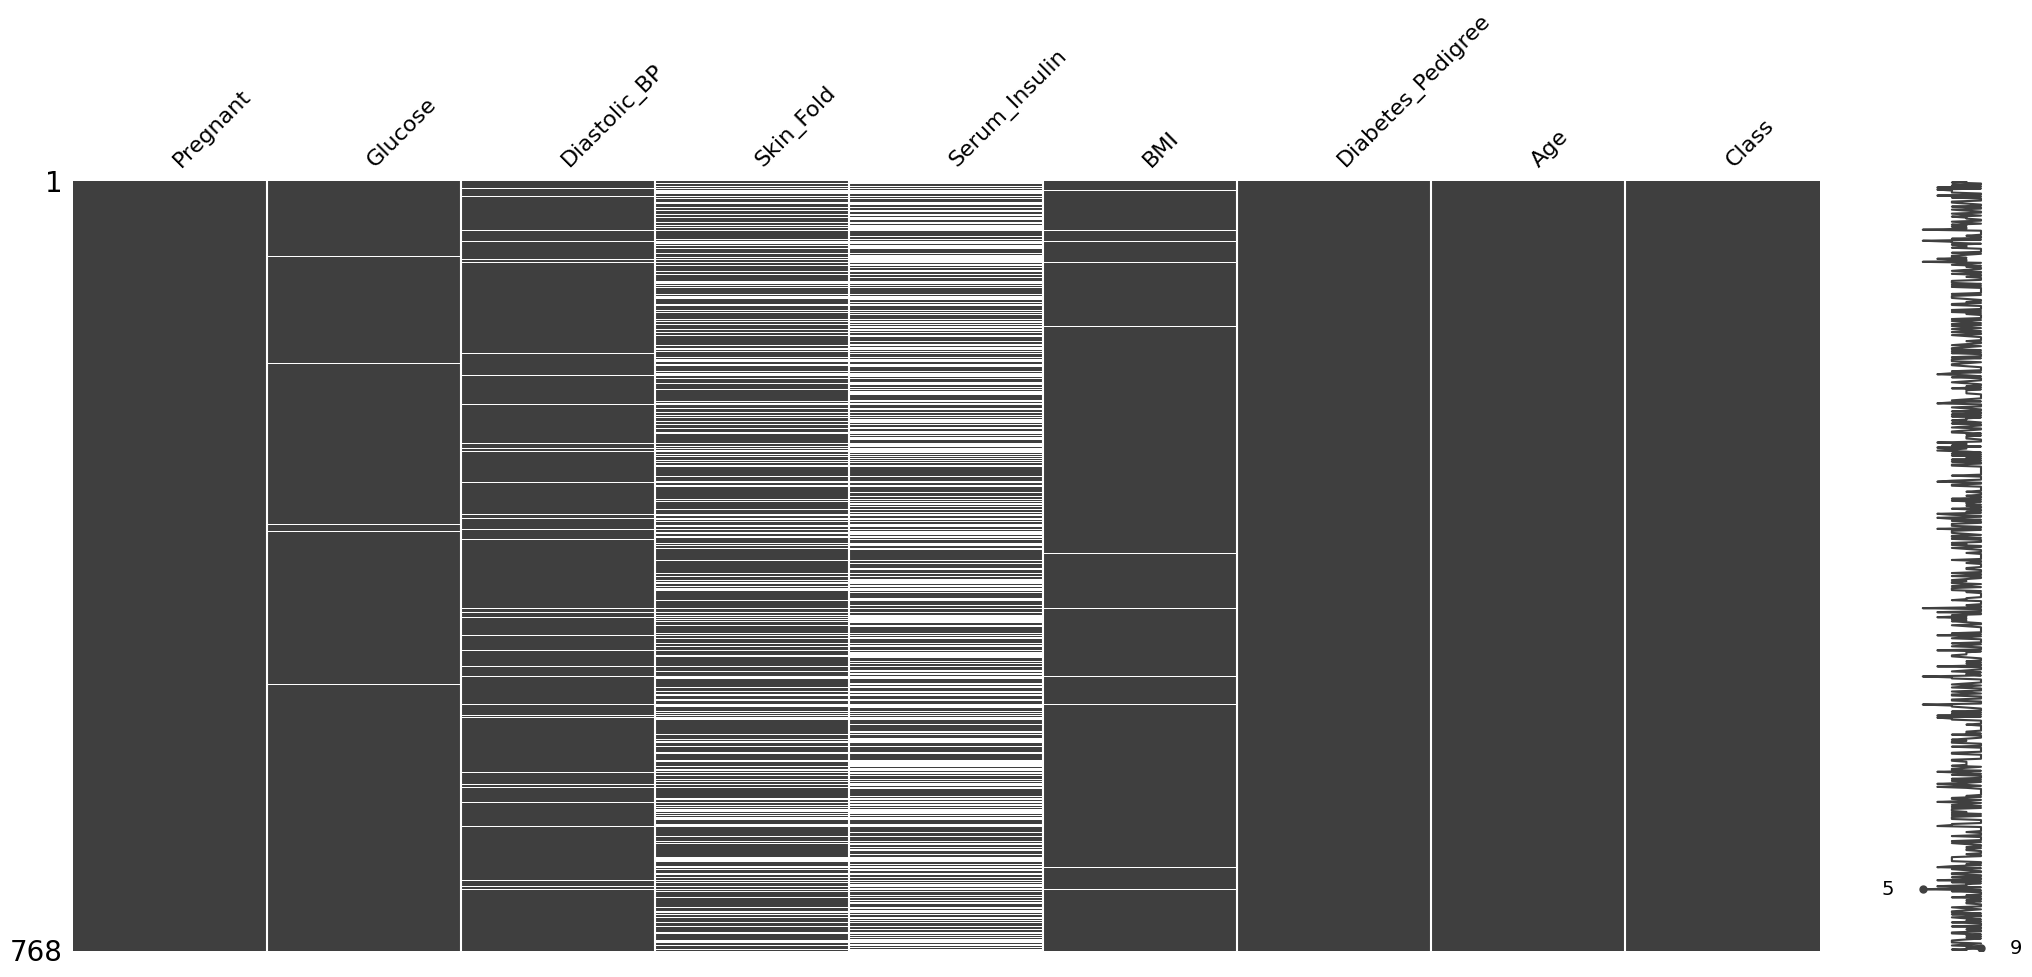

In [24]:
# Visualize the missingness summary
msno.matrix(diabetes)

# Display nullity matrix
plt.show()

The msno.matrix nullity matrix is a data-dense display which lets you quickly visually pick out patterns in data completion.

The sparkline at right summarizes the general shape of the data completeness and points out the rows with the maximum and minimum nullity in the dataset.

Finding correlations between missing data helps you gain a deeper understanding of the type of missing data as well as provides suitable ways in which the missing values can be addressed. 

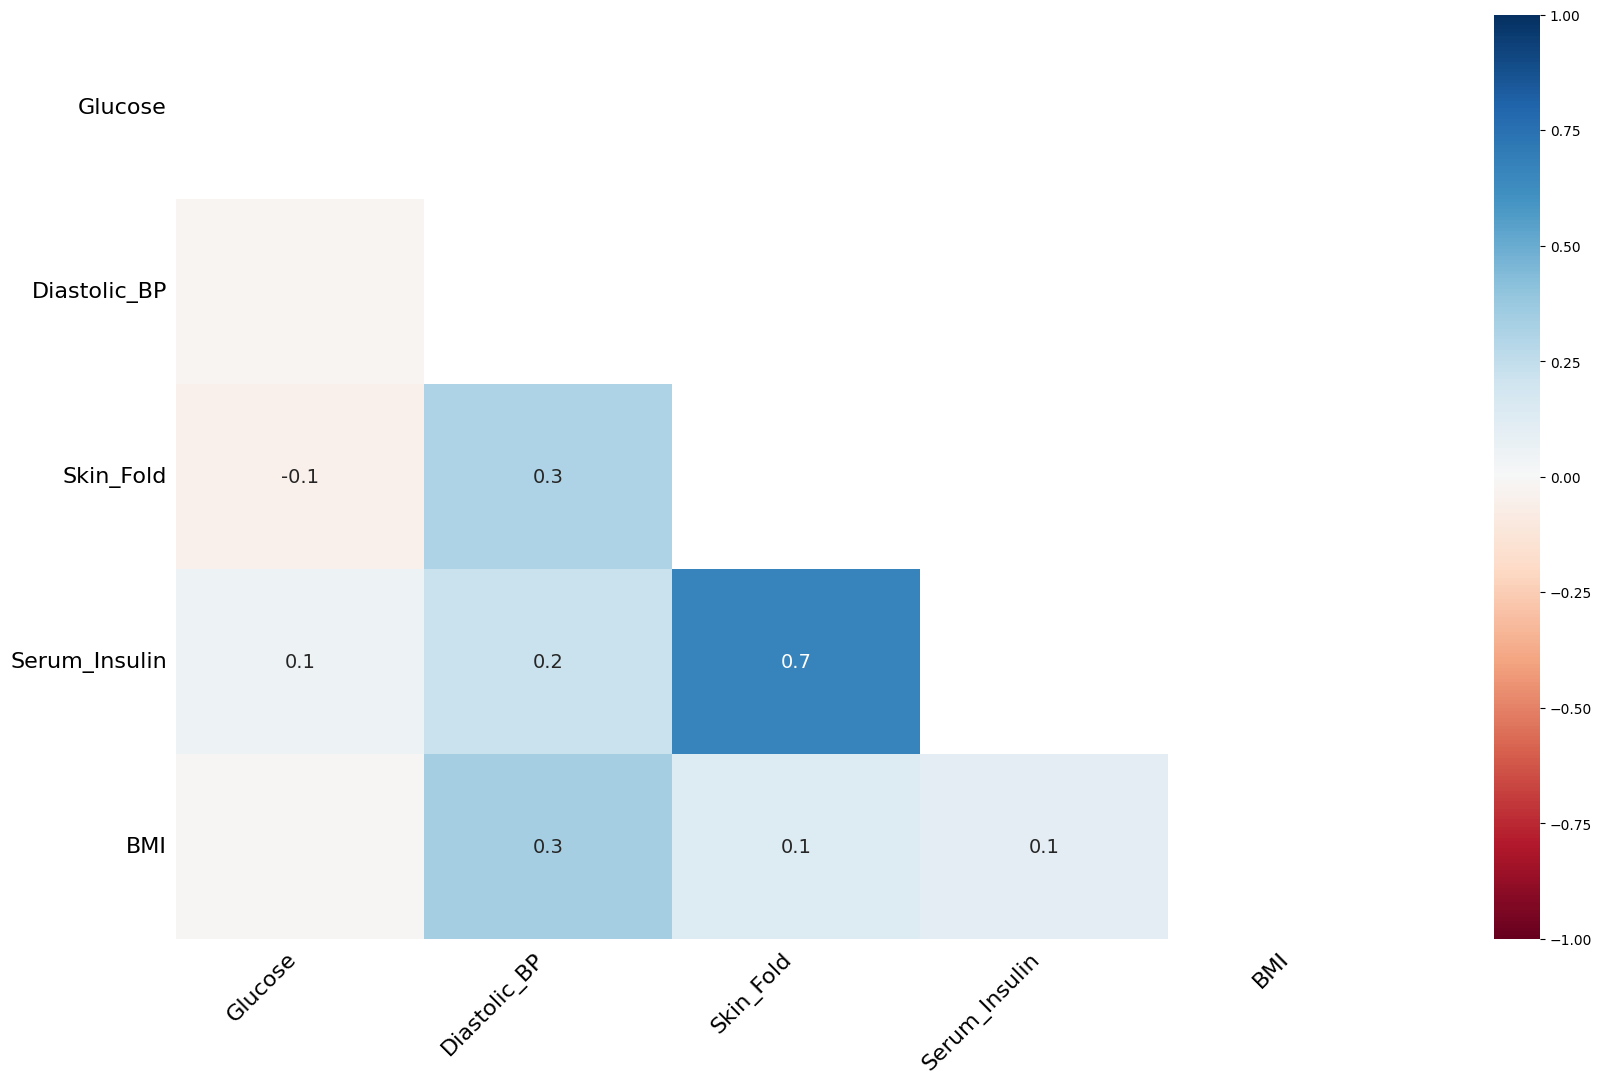

In [25]:
# Plot missingness heatmap of diabetes
msno.heatmap(diabetes)
# Show plot
plt.show()

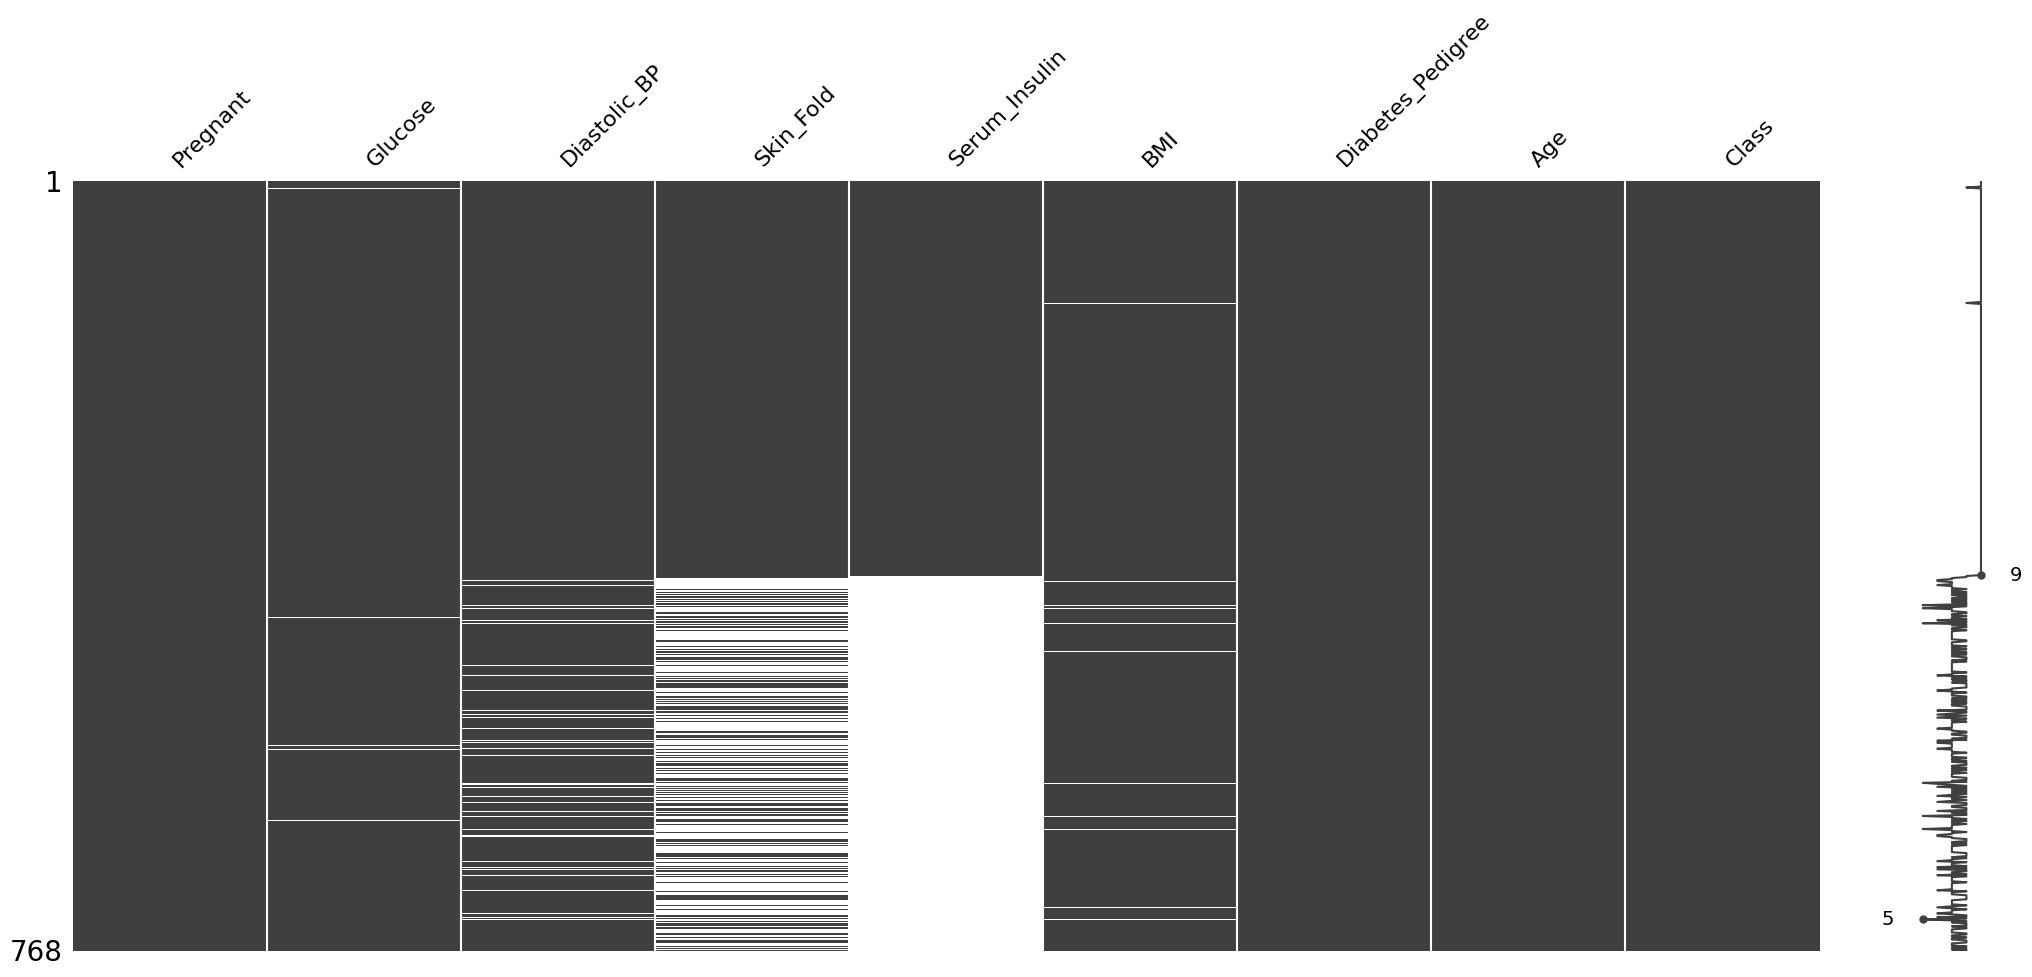

In [27]:
# Sort diabetes dataframe on 'Serum Insulin'
sorted_values = diabetes.sort_values("Serum_Insulin")

# Visualize the missingness summary of sorted
msno.matrix(sorted_values)

# Display nullity matrix
plt.show()

In [28]:
# Drop all rows where 'Glucose' has a missing value
diabetes = diabetes.dropna(subset=["Glucose"], how="all")

In [29]:
# Drop rows where 'BMI' has a missing value
diabetes = diabetes.dropna(subset=["BMI"], how="all")

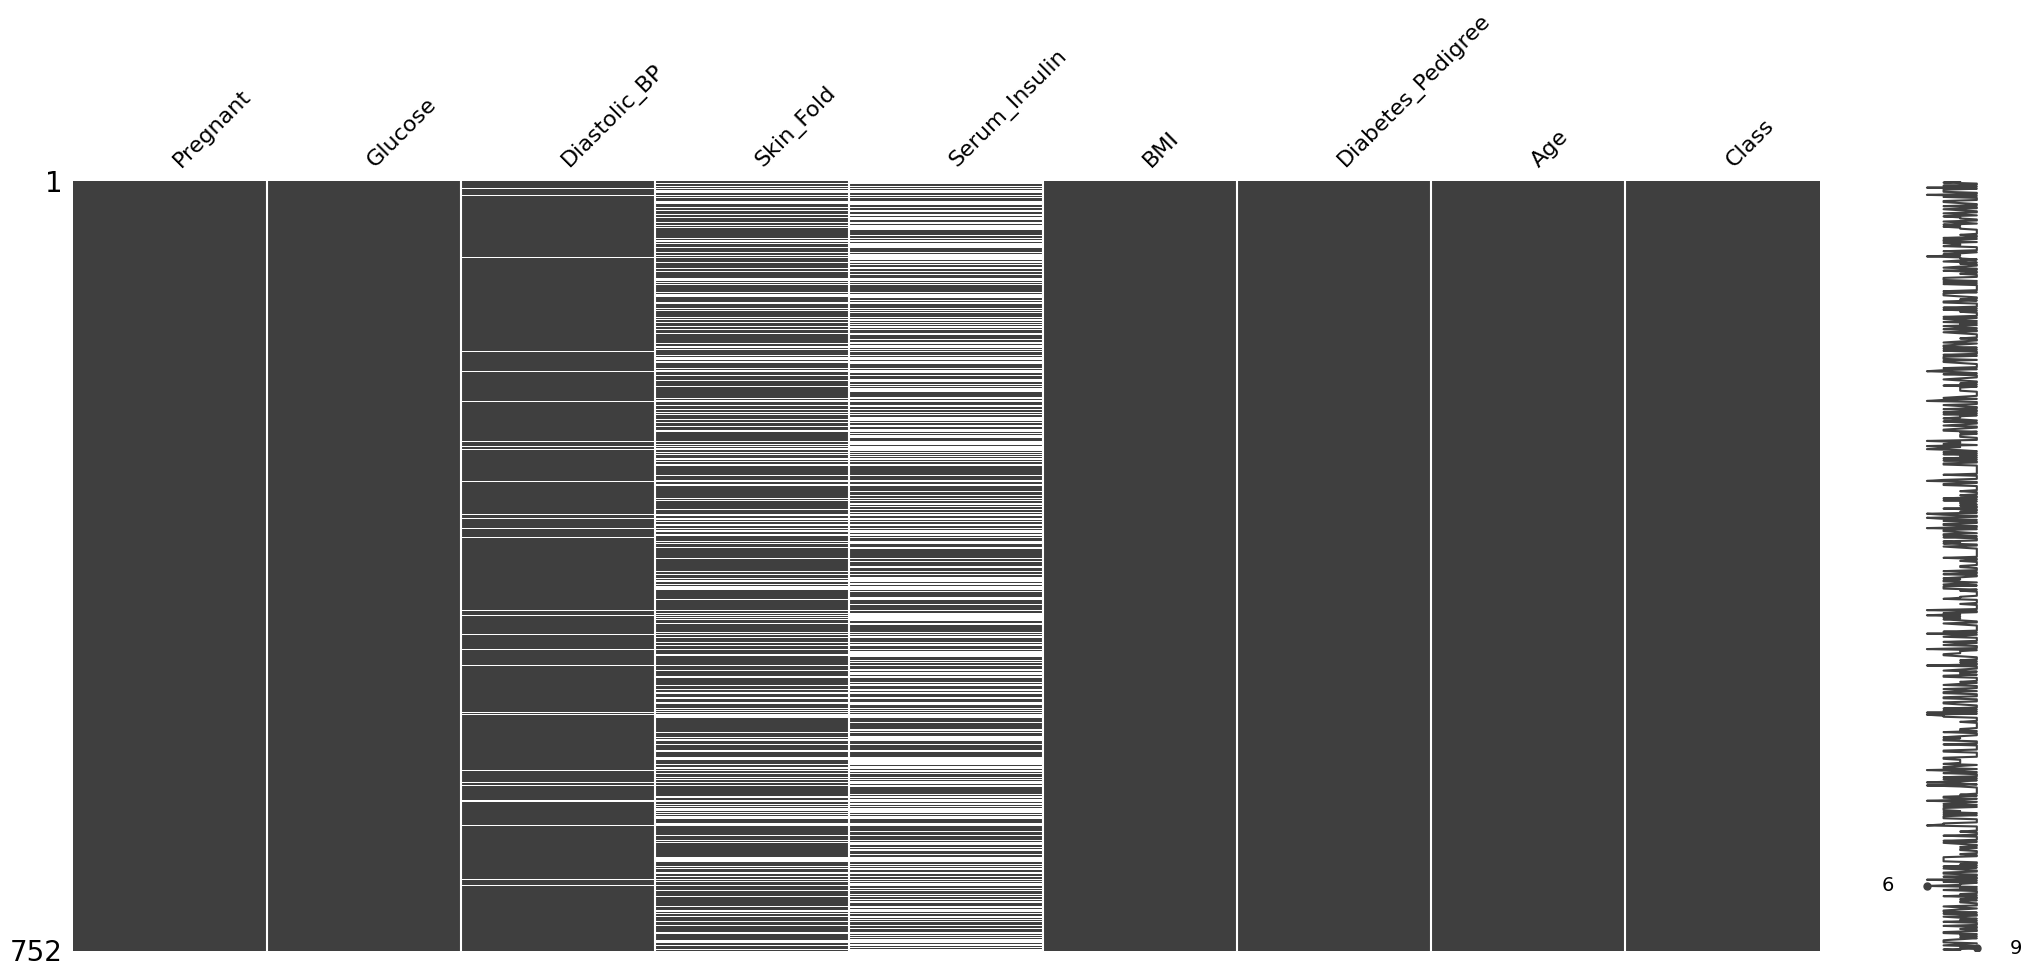

In [30]:
# Visualize the missingness in the data
msno.matrix(diabetes)
plt.show()